<a href="https://colab.research.google.com/github/Murilo1514/Diabets_predicion/blob/main/Projeto_Modelo_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predição de diabetes com modelos de IA

Dataset : https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

# Import das bibliotecas

In [1]:
!pip install optuna
!pip install ucimlrepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import optuna
from plotly.io import show
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo

Import do Dataset

In [3]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

df = cdc_diabetes_health_indicators.data.features
aux = cdc_diabetes_health_indicators.data.targets

df["diabetes"]= aux["Diabetes_binary"]

print(cdc_diabetes_health_indicators.metadata)
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

<ipython-input-3-1b5e75c6ba2c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4]:
df.sample(20)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
56618,0,1,1,24,0,0,0,1,1,1,...,1,2,0,7,0,1,7,6,8,0
44256,0,0,1,24,0,0,0,1,1,1,...,0,3,0,2,0,1,9,6,8,0
106247,0,0,1,20,1,0,0,1,0,0,...,0,2,0,0,0,1,1,3,5,0
78042,0,0,1,28,0,0,0,0,1,0,...,0,2,0,0,0,1,10,6,8,0
96502,0,0,1,29,1,0,0,1,1,1,...,0,2,0,0,0,0,2,5,6,0
119432,1,0,1,38,0,0,0,0,1,1,...,0,5,10,30,1,0,12,5,4,0
163428,0,0,1,22,1,0,0,1,1,1,...,1,3,30,0,0,0,8,4,4,0
212351,0,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,5,7,0
248889,0,1,1,20,1,0,0,1,1,1,...,0,1,0,0,0,0,11,6,6,0
8348,0,0,1,21,0,0,0,1,1,1,...,0,5,0,30,0,1,13,5,5,0


### Separação de conjuntos estratificados de aprendizado e teste

In [5]:
# Separação de conjuntos estratificados de aprendizado e teste
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

print(y_train.value_counts())
print(y_test.value_counts())

diabetes
0    174667
1     28277
Name: count, dtype: int64
diabetes
0    43667
1     7069
Name: count, dtype: int64


## Pipeline Logistic Regression

In [8]:
# Definindo quais são as colunas numéricas e categóricas
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

preprocessor_lr = ColumnTransformer( #normalizando numéricos e one-hot encoding para categóricos
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor_lr),
    ('log_reg', LogisticRegression())
])




AttributeError: 'Pipeline' object has no attribute 'head'

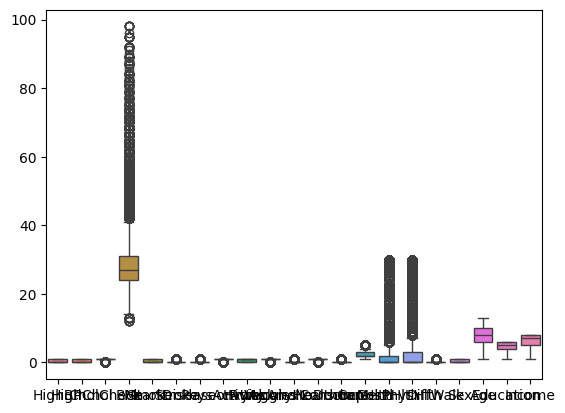

In [ ]:
sns.boxplot(data=X)
plt.show()

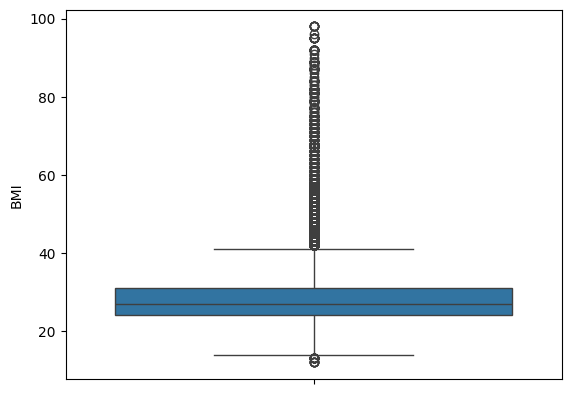

In [ ]:
sns.boxplot(data=X["BMI"])
plt.show()

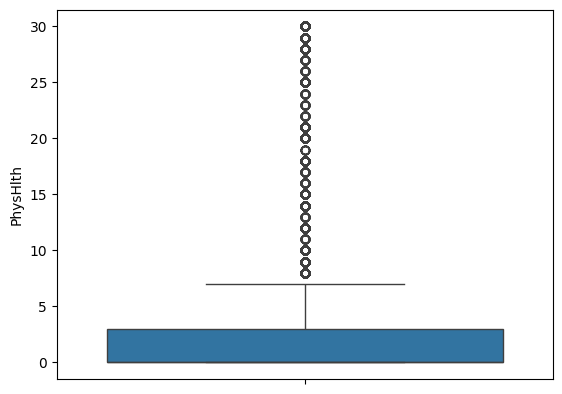

In [ ]:
sns.boxplot(data=X["PhysHlth"])
plt.show()

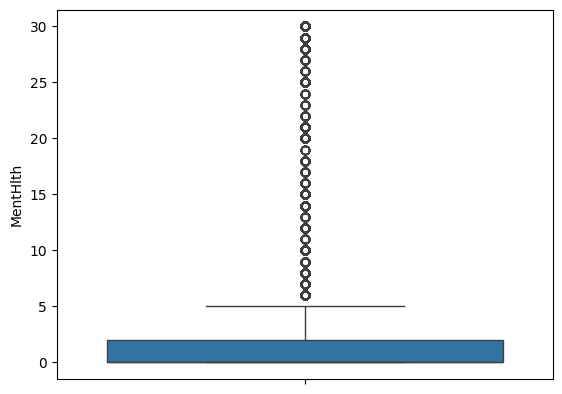

In [ ]:
sns.boxplot(data=X["MentHlth"])
plt.show()

In [ ]:
print(max(X["BMI"]))

98


# Seleção de hiperparâmetros

In [ ]:
x_train_split, x_validation, y_train_split, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=10, stratify=y_train)

### Optuna:

In [ ]:
def objective(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    if solver == 'lbfgs':
        penalty = 'l2'  # lbfgs só suporta 'l2'
    else:
        penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])  # liblinear e saga suportam 'l1' e 'l2'

    C = trial.suggest_float('C', 0.01, 10.0)

    pipe_lr = Pipeline([
        ('log_reg', LogisticRegression(solver=solver, penalty=penalty, C=C, max_iter=500))
    ])

    pipe_lr.fit(x_train_split, y_train_split)
    y_pred = pipe_lr.predict(x_validation)

    score = f1_score(y_validation, y_pred)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

print(study.best_params)

[I 2024-10-23 15:53:47,568] A new study created in memory with name: no-name-c8fdeb0a-9473-4b1c-9358-322a7cdbc33a
[I 2024-10-23 15:53:56,201] Trial 0 finished with value: 0.2474086197490453 and parameters: {'solver': 'lbfgs', 'C': 3.4814664320952597}. Best is trial 0 with value: 0.2474086197490453.
[I 2024-10-23 15:54:05,758] Trial 1 finished with value: 0.2479901893991007 and parameters: {'solver': 'lbfgs', 'C': 5.990133254708264}. Best is trial 1 with value: 0.2479901893991007.
[I 2024-10-23 15:55:26,935] Trial 2 finished with value: 0.2480916030534351 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 1.380283030238377}. Best is trial 2 with value: 0.2480916030534351.
[I 2024-10-23 15:55:32,404] Trial 3 finished with value: 0.24720327421555252 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 5.4689351097684975}. Best is trial 2 with value: 0.2480916030534351.
[I 2024-10-23 15:55:40,463] Trial 4 finished with value: 0.24778519830993595 and parameters: {'solver': 'l

{'solver': 'lbfgs', 'C': 4.087643013006603}


In [ ]:
print(y)

0         0
1         0
2         0
3         0
4         0
         ..
253675    0
253676    1
253677    0
253678    0
253679    1
Name: diabetes, Length: 253680, dtype: int64


In [ ]:
fig = optuna.visualization.plot_contour(study, params=["solver", "penalty", "C"])
show(fig)

In [ ]:
param_grid = [
    {
        'log_reg__solver': ['liblinear'],
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__C': np.logspace(-3, 3, 7)
    },
    {
        'log_reg__solver': ['lbfgs', 'saga'],
        'log_reg__penalty': ['l2'],
        'log_reg__C': np.logspace(-3, 3, 7)
    }
]

In [ ]:
f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, cv=5, scoring=f1_scorer)

grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'log_reg__C': 1000.0, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
0.24164865404207


# Análise do melhor valor de Hiperparâmetros de C

obs2: cuidado ao executar novamente essa célula, VAI DEMORAR MUITO

In [ ]:
dict_lr = {}

# Avaliar diferentes valores de C
for C_value in np.logspace(-3, 3, 30):
    pipe_lr_2 = Pipeline([
        ('preprocessor', preprocessor_lr),
        ('log_reg', LogisticRegression(C=C_value, solver='liblinear', max_iter=500))
    ])

    pipe_lr_2.fit(x_train, y_train)
    y_pred_2 = pipe_lr_2.predict(x_test)

    acertos = accuracy_score(y_test, y_pred_2)
    dict_lr[C_value] = round(acertos, 4)

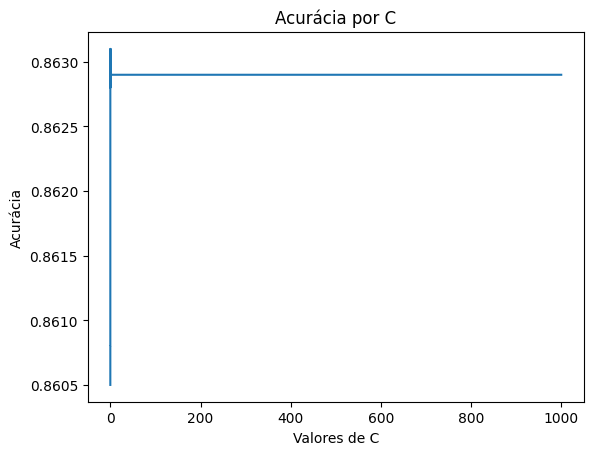

O melhor valor para C é: 0.18873918221350977. Com uma acurácia de 0.8631



Para C = 0.001, a acurácia é 0.8605
Para C = 0.0016102620275609393, a acurácia é 0.8608
Para C = 0.002592943797404667, a acurácia é 0.8608
Para C = 0.0041753189365604, a acurácia é 0.8616
Para C = 0.006723357536499335, a acurácia é 0.8624
Para C = 0.010826367338740546, a acurácia é 0.8629
Para C = 0.017433288221999882, a acurácia é 0.863
Para C = 0.02807216203941177, a acurácia é 0.863
Para C = 0.04520353656360243, a acurácia é 0.863
Para C = 0.0727895384398315, a acurácia é 0.8628
Para C = 0.11721022975334805, a acurácia é 0.8629
Para C = 0.18873918221350977, a acurácia é 0.8631
Para C = 0.3039195382313198, a acurácia é 0.863
Para C = 0.4893900918477494, a acurácia é 0.8631
Para C = 0.7880462815669912, a acurácia é 0.863
Para C = 1.2689610031679222, a acurácia é 0.8629
Para C = 2.0433597178569416, a acurácia é 0.8629
Para C = 3.2903445623126677, a acurácia é 0.8629
Para C = 5.298316906283707, a acurácia é 0.86

In [ ]:
plt.plot(list(dict_lr.keys()), list(dict_lr.values()))
plt.title("Acurácia por C")
plt.xlabel("Valores de C")
plt.ylabel("Acurácia")
plt.show()

better_C = max(dict_lr, key=dict_lr.get)
print(f"O melhor valor para C é: {better_C}. Com uma acurácia de {dict_lr[better_C]}")

print("\n\n")
for C_value in dict_lr:
    print(f"Para C = {C_value}, a acurácia é {dict_lr[C_value]}")